# 🚀 Demo of Company Name Matcher

This notebook demostrates the basic use cases of Company Name Matcher and compares it with other matching techniques (e.g., RapidFuzz).

# Import and Setup

In [ ]:
!pip install RapidFuzz pandas company-name-matcher

In [ ]:
!pip install matplotlib seaborn

In [1]:
import pandas as pd # Data I/O 
import re # Preprocess
from rapidfuzz import fuzz # matcher 1
from company_name_matcher import CompanyNameMatcher # matcher 2

# Initialize the matchers

## Rapid Fuzz

In [2]:
def rapid_fuzz_matcher(x1, x2):
    return fuzz.ratio(x1, x2) / 100

## Matcher with a default model

In [3]:
# Simple function to clean the names; we can further remove the stops words (e.g., limited, inc) if needed.
def preprocess_name1(name):
    return re.sub(r'[^a-zA-Z0-9\s]', '', name.lower()).strip()
    
default_matcher = CompanyNameMatcher(
    "paraphrase-multilingual-MiniLM-L12-v2", 
    preprocess_fn = preprocess_name1
)

## Matcher with a fine-tuned model

In [4]:
def preprocess_name2(name):
    return "#" + name.strip() + "#" # Pretrained tokens
    
finetuned_matcher = CompanyNameMatcher(
    "models/multilingual-MiniLM-small-v1", 
    preprocess_fn = preprocess_name2
)

# 1. Pair-wise matching

In [5]:
basic_companies = [
    "Microsoft Corporation",
    "Apple Inc",
    "Google",
    "Apple Computer Inc",
    "苹果公司",          # Apple Inc. in Chinese
]
for company in basic_companies:
    similarity1 = rapid_fuzz_matcher("Apple", company)
    similarity2 = default_matcher.compare_companies("Apple", company)
    similarity3 = finetuned_matcher.compare_companies("Apple", company)
    print(f"Apple vs {company}")
    print("-" * 50)
    print(f"Rapid Fuzz: {similarity1: .2f}")
    print(f"Default Matcher: {similarity2: .2f}")
    print(f"Finetuned Matcher: {similarity3: .2f}")
    print("\n")

Apple vs Microsoft Corporation
--------------------------------------------------
Rapid Fuzz:  0.08
Default Matcher:  0.34
Finetuned Matcher:  0.32


Apple vs Apple Inc
--------------------------------------------------
Rapid Fuzz:  0.71
Default Matcher:  0.91
Finetuned Matcher:  0.83


Apple vs Google
--------------------------------------------------
Rapid Fuzz:  0.36
Default Matcher:  0.32
Finetuned Matcher:  0.56


Apple vs Apple Computer Inc
--------------------------------------------------
Rapid Fuzz:  0.43
Default Matcher:  0.84
Finetuned Matcher:  0.74


Apple vs 苹果公司
--------------------------------------------------
Rapid Fuzz:  0.00
Default Matcher:  0.31
Finetuned Matcher:  0.90




# 2. Bulk matching

In [6]:
import requests

In [7]:
url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/refs/heads/main/data/constituents.csv"
response = requests.get(url)  # Skipping SSL verification
with open("companies.csv", "wb") as file:
    file.write(response.content)
data = pd.read_csv("companies.csv")

In [8]:
data.head(1)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902


## Build, Load, Expend Index

We only need to build index once

In [9]:
# We can have further cleaning here
companies_to_match = data["Security"].to_list()

In [10]:
finetuned_matcher.build_index(
    companies_to_match, 
    n_clusters = 10, 
    save_dir="index_files"
)

Next time, we can simply load the saved index files

In [11]:
finetuned_matcher.load_index(load_dir="index_files")

We can optionally expend the index without rebuilding the whole index

In [12]:
new_companies = [
    "ABC Limited",
    # ...
]

In [13]:
finetuned_matcher.expand_index(
    new_companies, 
    save_dir="index_files" # Update the existing index files
)

## 🐢 Exact Search

In [14]:
%%time

print("Exact Search Results:")
exact_matches = finetuned_matcher.find_matches(
    ["Palantir", "3m Company", "ABC Ltd"],
    k = 1, 
    threshold=0.8,
    use_approx=False,
)
print(f"Exact matches: {exact_matches}\n")

Exact Search Results:
Exact matches: [[('Palantir Technologies', 0.8237564)], [('3M', 0.830296)], [('ABC Limited', 0.8869119)]]

CPU times: user 618 ms, sys: 31.1 ms, total: 649 ms
Wall time: 217 ms


## 🐇 Approximate Search 

In [15]:
%%time

print("Approximate Search Results:")
approx_matches = finetuned_matcher.find_matches(
    ["Palantir", "3m Company", "ABC Ltd"],
    threshold=0.8,
    k = 1, 
    use_approx=True, 
    n_probe_clusters = 3, # Increase this to increase performance
    
)
print(f"Approximate matches: {approx_matches}\n")

Approximate Search Results:
Approximate matches: [[('Palantir Technologies', 0.8237565)], [('3M', 0.83029616)], [('ABC Limited', 0.8869118)]]

CPU times: user 66 ms, sys: 73.8 ms, total: 140 ms
Wall time: 49.3 ms


## 🐆 Parallel Approximate Search

In [16]:
%%time

print("Approximate Search Results:")
approx_matches = finetuned_matcher.find_matches(
    ["Palantir", "3m Company"],
    threshold=0.8,
    k=1,
    use_approx=True, 
    n_jobs = 2
)


Approximate Search Results:
CPU times: user 235 ms, sys: 297 ms, total: 533 ms
Wall time: 179 ms


# 3. Working with Embeddings

In [17]:
print("3. Working with Embeddings")
print("-" * 40)
# Single company embedding
single_embedding = finetuned_matcher.get_embedding("Apple Inc")
print(f"Single company embedding shape: {single_embedding.shape}")


3. Working with Embeddings
----------------------------------------
Single company embedding shape: (384,)


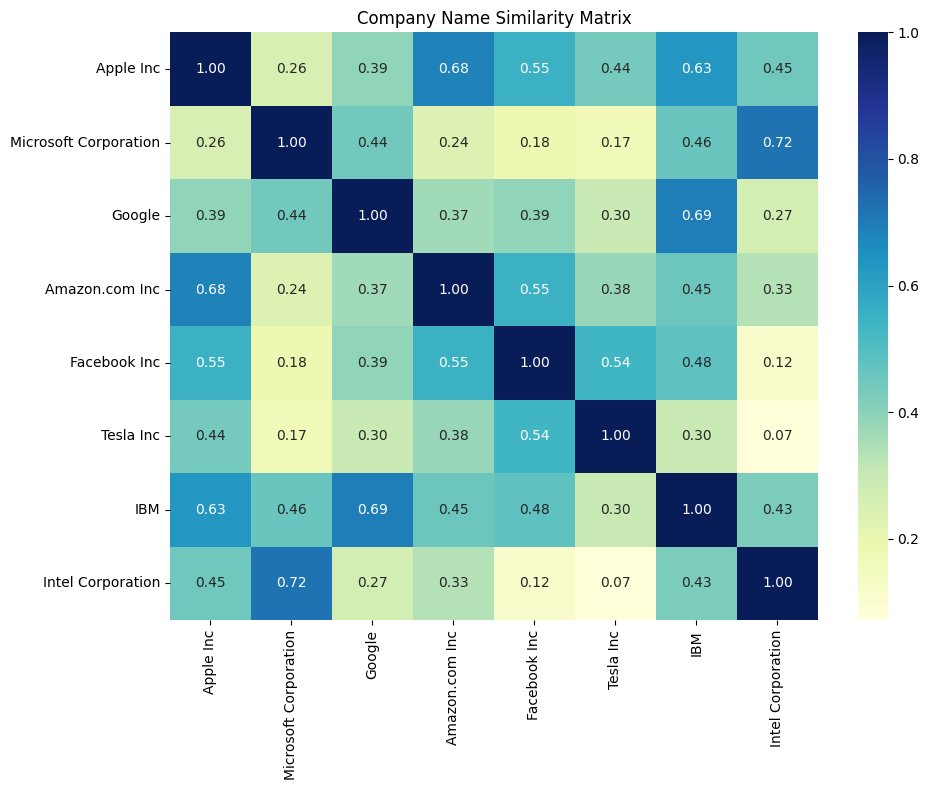

In [18]:
# Visualize similarities between companies
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Select a few companies to compare
companies_to_visualize = [
    "Apple Inc", 
    "Microsoft Corporation", 
    "Google", 
    "Amazon.com Inc", 
    "Facebook Inc",
    "Tesla Inc",
    "IBM",
    "Intel Corporation"
]

# Get embeddings for all companies
embeddings = {company: finetuned_matcher.get_embedding(company) for company in companies_to_visualize}

# Calculate similarity matrix
similarity_matrix = np.zeros((len(companies_to_visualize), len(companies_to_visualize)))
for i, company1 in enumerate(companies_to_visualize):
    for j, company2 in enumerate(companies_to_visualize):
        # Calculate cosine similarity between embeddings
        similarity = finetuned_matcher.compare_companies(company1, company2)
        similarity_matrix[i, j] = similarity

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=companies_to_visualize, yticklabels=companies_to_visualize)
plt.title("Company Name Similarity Matrix")
plt.tight_layout()
plt.show()

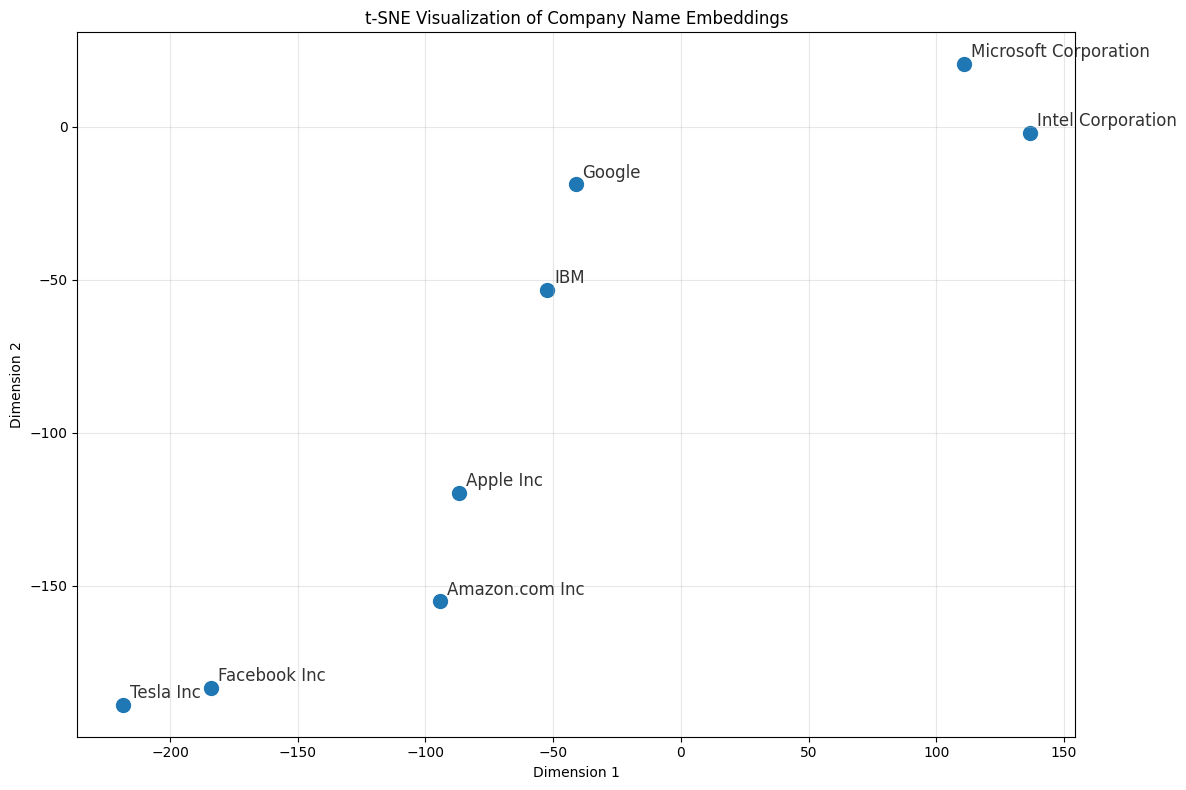

In [19]:
# Visualize embeddings in 2D using t-SNE
from sklearn.manifold import TSNE

# Convert embeddings to a list of arrays
embedding_list = np.array([embeddings[company] for company in companies_to_visualize])

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
embeddings_2d = tsne.fit_transform(embedding_list)

# Plot the 2D embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100)

# Add labels for each point
for i, company in enumerate(companies_to_visualize):
    plt.annotate(company, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                 fontsize=12, alpha=0.8, 
                 xytext=(5, 5), textcoords='offset points')

plt.title("t-SNE Visualization of Company Name Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()